In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.stats import pearsonr, ttest_ind

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'AppleGothic' (Mac 사용 시)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 설명변수 생성, 전력 수요와의 상관성 관찰

In [47]:
# 데이터 불러오기
data = pd.read_csv('C:/Users/LG/Desktop/elec/elecdata_20241128.csv')

# 날짜 형식 변환
data['date'] = pd.to_datetime(data['date'])

# 'weekend' 변수 생성
data['weekend'] = data['day'].apply(lambda x: 1 if x in [1, 7] else 0)

# 'temp_abs' 변수 생성: 온도의 절대편차 |temperature - 15|
data['temp_abs'] = np.abs(data['temp'] - 15)

# 'time' 변수 생성 (시간 순서 인덱스)
data['time'] = np.arange(len(data))

# 결측치 확인 및 제거
print(data.isnull().sum())
data = data.dropna()

# 변수 타입 변환
data['weekend'] = data['weekend'].astype(int)
data['holiday'] = data['holiday'].astype(int)

In [3]:
#데이터 확인
data.head()

,date,temp,watt,pwatt,day,holiday,weekend,temp_abs,time
0,2010-01-01,-4.9,56391,56391,6,0,0,19.9,0
1,2010-01-02,-0.1,55470,56391,7,1,1,15.1,1
2,2010-01-03,-2.9,55581,55470,1,1,1,17.9,2
3,2010-01-04,-1.8,66149,55581,2,1,0,16.8,3
4,2010-01-05,-5.2,66901,66149,3,1,0,20.2,4


In [4]:
# 주요 변수에 대한 기초통계량
print("기초통계량:")
print(data[['watt', 'temp', 'temp_abs']].describe().round(3))

기초통계량:
            watt      temp  temp_abs
count   5442.000  5442.000  5442.000
mean   67661.333    13.279     8.398
std     8948.346     9.686     5.122
min    38764.000   -12.300     0.000
25%    61176.000     4.900     4.300
50%    67068.000    14.100     8.100
75%    73145.500    21.800    11.900
max    97115.000    30.300    27.300


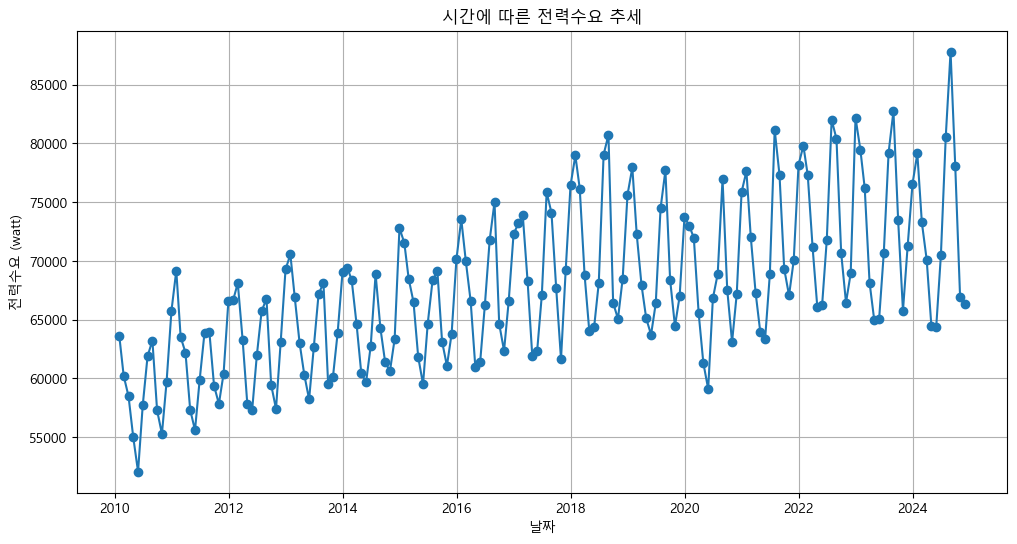

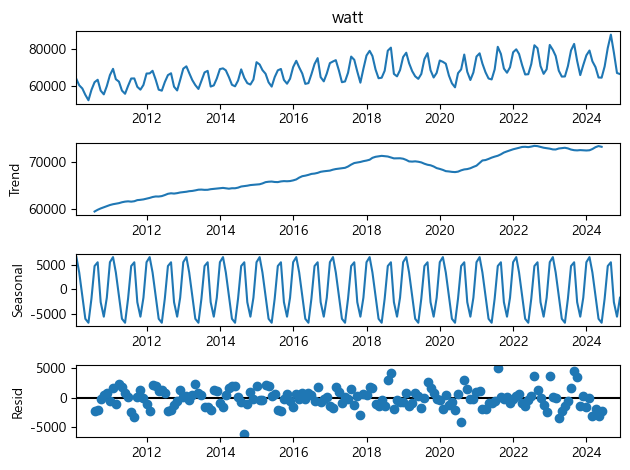

In [5]:
# Convert the date column to a datetime format and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Resample data to monthly averages for seasonal trend analysis
monthly_data = data['watt'].resample('M').mean()

# Plot the monthly trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, marker='o')
plt.title("시간에 따른 전력수요 추세")
plt.xlabel("날짜")
plt.ylabel("전력수요 (watt)")
plt.grid(True)
plt.show()

# Decompose the time series to observe seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_data, model='additive', period=12)
decomposition.plot()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['watt'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.816129
p-value: 0.000000


In [9]:
import itertools

# 비계절 차수 범위
p = range(0, 3)
d = [0]  # 이미 d=0으로 결정됨
q = range(0, 3)

# 계절 차수 범위
P = range(0, 3)
D = [1]  # D=0으로 설정 (필요에 따라 1로 변경 가능)
Q = range(0, 3)
s = 7  # 주간 계절성

# 모든 조합 생성
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

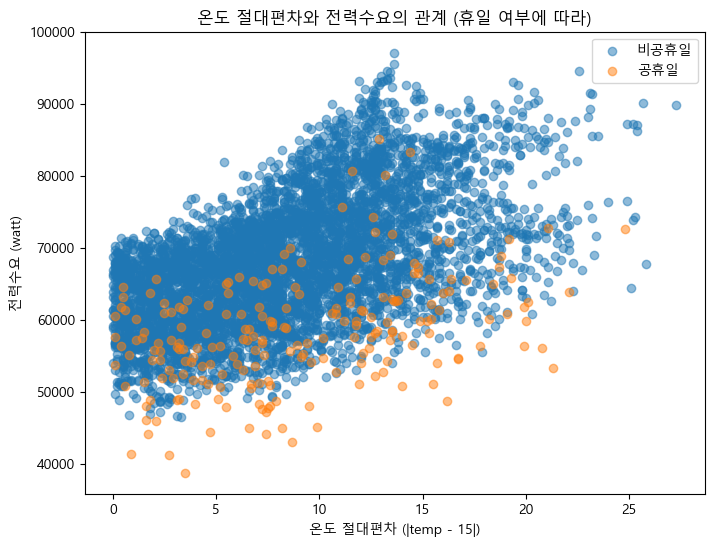

In [10]:
from scipy.stats import pearsonr

# 휴일과 비휴일 데이터로 분할
holiday_data = data[data['holiday'] == 0]
non_holiday_data = data[data['holiday'] == 1]

# 산점도 그리기
plt.figure(figsize=(8, 6))

plt.scatter(non_holiday_data['temp_abs'], non_holiday_data['watt'], label='비공휴일', alpha=0.5)
plt.scatter(holiday_data['temp_abs'], holiday_data['watt'], label='공휴일', alpha=0.5)

plt.title('온도 절대편차와 전력수요의 관계 (휴일 여부에 따라)')
plt.xlabel('온도 절대편차 (|temp - 15|)')
plt.ylabel('전력수요 (watt)')
plt.legend()
plt.show()

In [11]:
# 상관계수 계산
corr_holiday, p_value_holiday = pearsonr(holiday_data['temp_abs'], holiday_data['watt'])
corr_non_holiday, p_value_non_holiday = pearsonr(non_holiday_data['temp_abs'], non_holiday_data['watt'])

print(f"휴일의 온도 절대편차와 전력수요의 상관계수: {corr_holiday:.4f}, p-value: {p_value_holiday:.4f}")
print(f"비휴일의 온도 절대편차와 전력수요의 상관계수: {corr_non_holiday:.4f}, p-value: {p_value_non_holiday:.4f}")

휴일의 온도 절대편차와 전력수요의 상관계수: 0.4078, p-value: 0.0000
비휴일의 온도 절대편차와 전력수요의 상관계수: 0.5514, p-value: 0.0000


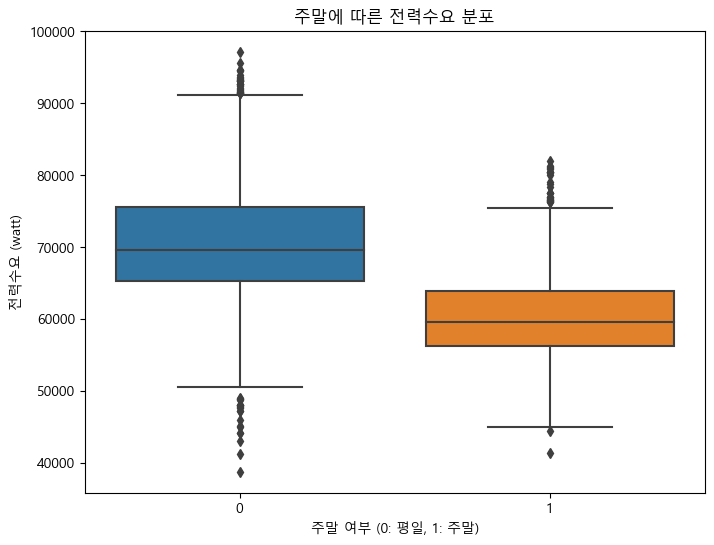

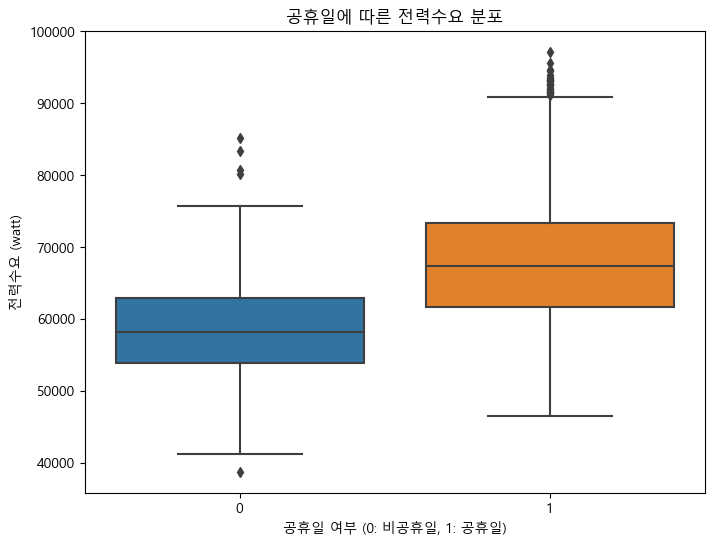

In [12]:
# 주말에 따른 전력수요 분포
plt.figure(figsize=(8, 6))
sns.boxplot(x='weekend', y='watt', data=data)
plt.title('주말에 따른 전력수요 분포')
plt.xlabel('주말 여부 (0: 평일, 1: 주말)')
plt.ylabel('전력수요 (watt)')
plt.show()

# 공휴일에 따른 전력수요 분포
plt.figure(figsize=(8, 6))
sns.boxplot(x='holiday', y='watt', data=data)
plt.title('공휴일에 따른 전력수요 분포')
plt.xlabel('공휴일 여부 (0: 비공휴일, 1: 공휴일)')
plt.ylabel('전력수요 (watt)')
plt.show()

In [13]:
# 주말과 평일의 전력수요 데이터 분리
weekend_watt = data[data['weekend'] == 1]['watt']
weekday_watt = data[data['weekend'] == 0]['watt']

# 등분산 검정
from scipy.stats import levene
levene_stat, levene_p = levene(weekend_watt, weekday_watt)

# 등분산 여부에 따른 t-검정
equal_var = True if levene_p > 0.05 else False

t_stat, p_value = ttest_ind(weekend_watt, weekday_watt, equal_var=equal_var)
print(f"t-통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

alpha = 0.05

# 결과 해석
if p_value < alpha:
    print("유의수준 5%에서 귀무가설을 기각합니다. 주말과 평일의 전력수요 평균에 차이가 있습니다.")
else:
    print("유의수준 5%에서 귀무가설을 채택합니다. 주말과 평일의 전력수요 평균에 차이가 없습니다.")

t-통계량: -50.4303, p-value: 0.0000
유의수준 5%에서 귀무가설을 기각합니다. 주말과 평일의 전력수요 평균에 차이가 있습니다.


In [14]:
# 공휴일과 비공휴일의 전력수요 데이터 분리
holiday_watt = data[data['holiday'] == 1]['watt']
non_holiday_watt = data[data['holiday'] == 0]['watt']

# 등분산 검정
levene_stat, levene_p = levene(holiday_watt, non_holiday_watt)

# 등분산 여부에 따른 t-검정
equal_var = True if levene_p > 0.05 else False

t_stat, p_value = ttest_ind(holiday_watt, non_holiday_watt, equal_var=equal_var)
print(f"t-통계량: {t_stat:.4f}, p-value: {p_value:.4f}")

# 결과 해석
if p_value < alpha:
    print("유의수준 5%에서 귀무가설을 기각합니다. 공휴일과 비공휴일의 전력수요 평균에 차이가 있습니다.")
else:
    print("유의수준 5%에서 귀무가설을 채택합니다. 공휴일과 비공휴일의 전력수요 평균에 차이가 없습니다.")

t-통계량: 18.0594, p-value: 0.0000
유의수준 5%에서 귀무가설을 기각합니다. 공휴일과 비공휴일의 전력수요 평균에 차이가 있습니다.


# 2. 모형 정의, 예측 수행

<Figure size 1200x600 with 0 Axes>

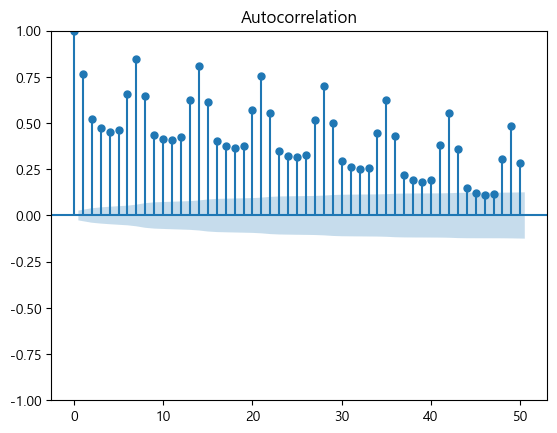

C:\Users\LG\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


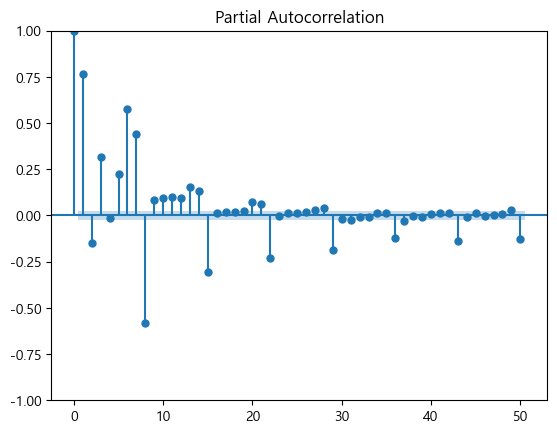

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 'watt' 변수의 ACF와 PACF 그래프
plt.figure(figsize=(12, 6))

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 그래프
plot_acf(data['watt'], lags=50)
plt.show()

# PACF 그래프
plot_pacf(data['watt'], lags=50)
plt.show()


plt.tight_layout()
plt.show()

In [16]:
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")  # 경고 메시지 무시

best_aic = float("inf")
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data['watt'],
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
            print('SARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
        except:
            continue

print('\n최적의 SARIMA{}x{} - AIC:{}'.format(best_order, best_seasonal_order, best_aic))

SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:107829.04233032097
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:106877.50415397868
SARIMA(0, 0, 0)x(0, 1, 2, 7) - AIC:106689.23686844169
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:106881.18119930118
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:106816.39978622616
SARIMA(0, 0, 0)x(1, 1, 2, 7) - AIC:106656.50808970109
SARIMA(0, 0, 0)x(2, 1, 0, 7) - AIC:106694.76289600806
SARIMA(0, 0, 0)x(2, 1, 1, 7) - AIC:106695.95151635673
SARIMA(0, 0, 0)x(2, 1, 2, 7) - AIC:106653.0328085388
SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:104946.5793447258
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:103970.07108270758
SARIMA(0, 0, 1)x(0, 1, 2, 7) - AIC:103810.53686797872
SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC:104090.97593405857
SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC:103951.34687427162
SARIMA(0, 0, 1)x(1, 1, 2, 7) - AIC:103808.32231363602
SARIMA(0, 0, 1)x(2, 1, 0, 7) - AIC:103489.84602059297
SARIMA(0, 0, 1)x(2, 1, 1, 7) - AIC:103849.34701048011
SARIMA(0, 0, 1)x(2, 1, 2, 7) - AIC:103808.22897119995
SARIMA(0, 0, 2)x(0, 1, 0, 7) -

In [18]:
data['lagwatt'] = data['watt'].shift(1)  # lag 1

# 결측치 제거 (lag로 인해 생긴 첫 번째 NaN 값)
data = data.dropna()

# 독립 변수와 종속 변수 설정
X = data[['lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X = sm.add_constant(X)  # 상수항 추가
y = data['watt']

# 최적 모델로 적합
model = sm.tsa.statespace.SARIMAX(y , exog = X,
                                  order=best_order,
                                  seasonal_order=best_seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# 결과 출력
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                   watt   No. Observations:                 5441
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 7)   Log Likelihood              -49319.137
Date:                                Tue, 03 Dec 2024   AIC                          98662.274
Time:                                        20:26:29   BIC                          98741.446
Sample:                                    01-02-2010   HQIC                         98689.910
                                         - 11-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   2.19e+04   9.04e-09      1.000    -4.3e+04     4.3e+04
lag

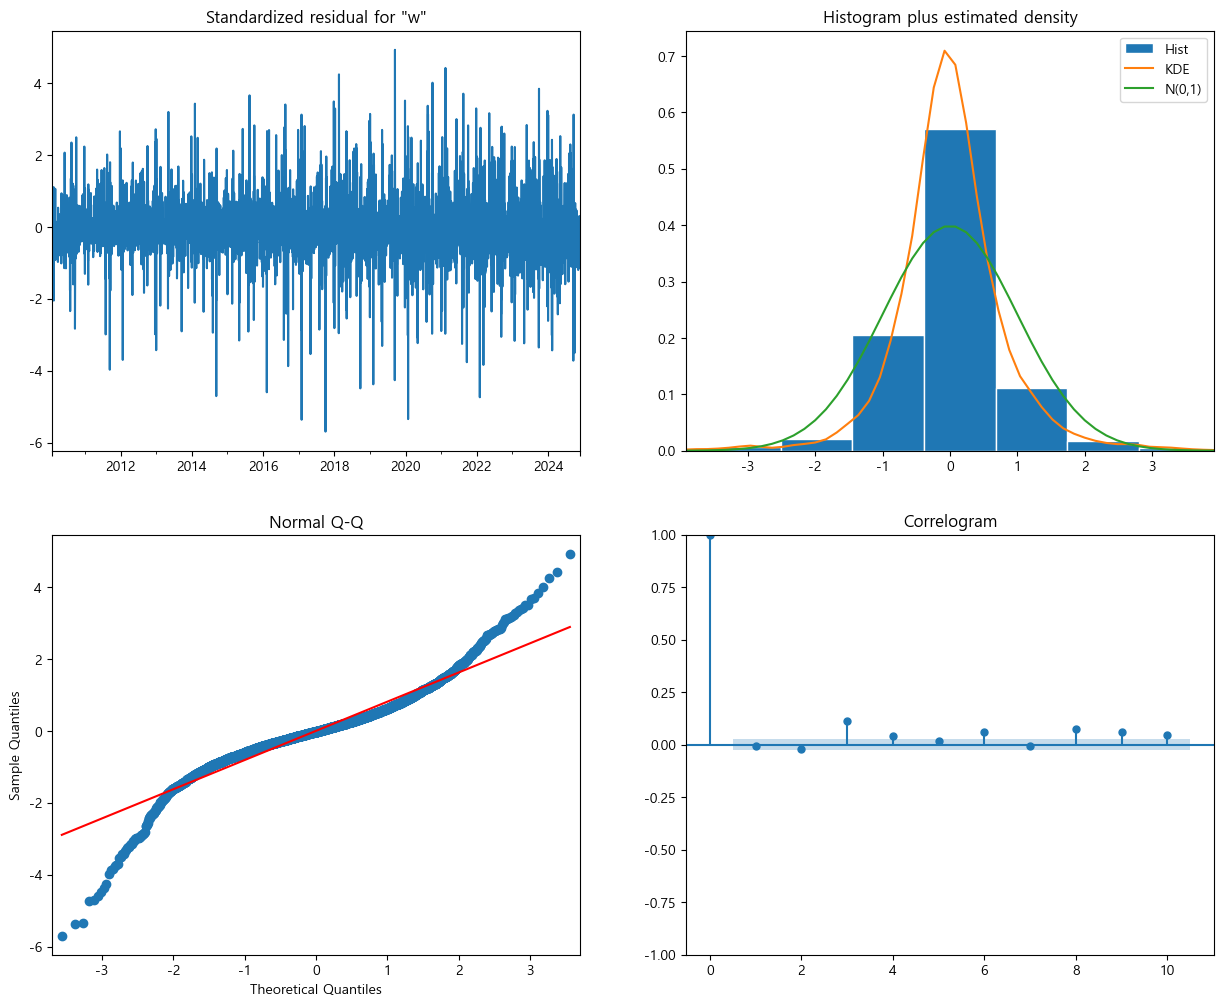

In [19]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [20]:
X = data[['lagwatt', 'time', 'temp_abs', 'holiday']] #weekend 변수가 유의 하지 않았기 때문에 제거하고 회귀모형을 다시 적합
X = sm.add_constant(X) 
y = data['watt']

# 최적 모델로 적합
model = sm.tsa.statespace.SARIMAX(y , exog = X,
                                  order=best_order,
                                  seasonal_order=best_seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# 결과 출력
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                   watt   No. Observations:                 5440
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 7)   Log Likelihood              -49311.267
Date:                                Tue, 03 Dec 2024   AIC                          98644.534
Time:                                        20:28:06   BIC                          98717.106
Sample:                                    01-03-2010   HQIC                         98669.866
                                         - 11-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   1.07e+04   1.97e-08      1.000    -2.1e+04     2.1e+04
lag

In [22]:
# 훈련 데이터: 2023년 12월 31일까지
train_data = data.loc[:'2023-12-31']

# 테스트 데이터: 2024년 1월 1일부터 2024년 11월 24일까지
test_data = data.loc['2024-01-01':'2024-11-24']

# 예측할 기간: 2024년 12월 1일부터 2024년 12월 31일까지 (날짜 생성)
forecast_dates = pd.date_range(start='2024-12-01', end='2024-12-31', freq='D')

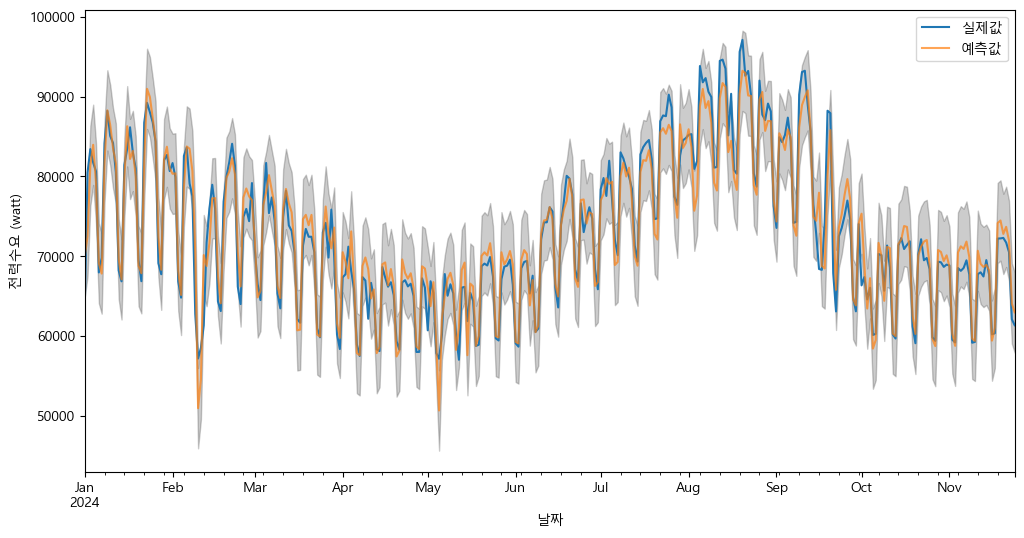

MSE: 6160446.88
MAE: 1854.15
RMSE: 2482.02
MAPE: 2.55%


In [23]:
# 테스트 데이터에 대한 예측
pred = results.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_ci = pred.conf_int()

# 실제 값과 예측값 비교
ax = test_data['watt'].plot(label='실제값', figsize=(12, 6))
pred.predicted_mean.plot(ax=ax, label='예측값', alpha=.7)

# 예측 구간 그림
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('날짜')
ax.set_ylabel('전력수요 (watt)')
plt.legend()
plt.show()

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_data['watt']
y_pred = pred.predicted_mean

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

In [25]:
# 전체 데이터로 모델 재적합 (훈련 데이터 + 테스트 데이터)
full_model = sm.tsa.statespace.SARIMAX(y,
                                       order=best_order,
                                       seasonal_order=best_seasonal_order,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
full_results = full_model.fit()

# 예측 수행
forecast = full_results.get_forecast(steps=len(forecast_dates))
forecast_ci = forecast.conf_int()

# 예측 결과 데이터프레임 생성
forecast_df = pd.DataFrame({'date': forecast_dates,
                            'predicted_watt': forecast.predicted_mean.values,
                            'lower_ci': forecast_ci.iloc[:, 0].values,
                            'upper_ci': forecast_ci.iloc[:, 1].values})

# 날짜를 인덱스로 설정
forecast_df.set_index('date', inplace=True)

forecast_df.round(3)

,predicted_watt,lower_ci,upper_ci
date,,,
2024-12-01,72213.493,65766.068,78660.917
2024-12-02,72904.201,64291.914,81516.488
2024-12-03,72626.601,62729.469,82523.733
2024-12-04,73293.583,62557.959,84029.207
2024-12-05,71926.650,60620.114,83233.187
2024-12-06,63060.571,51356.243,74764.900
2024-12-07,62263.353,50277.967,74248.739
2024-12-08,73124.144,60641.292,85606.996
2024-12-09,73851.893,61009.459,86694.326


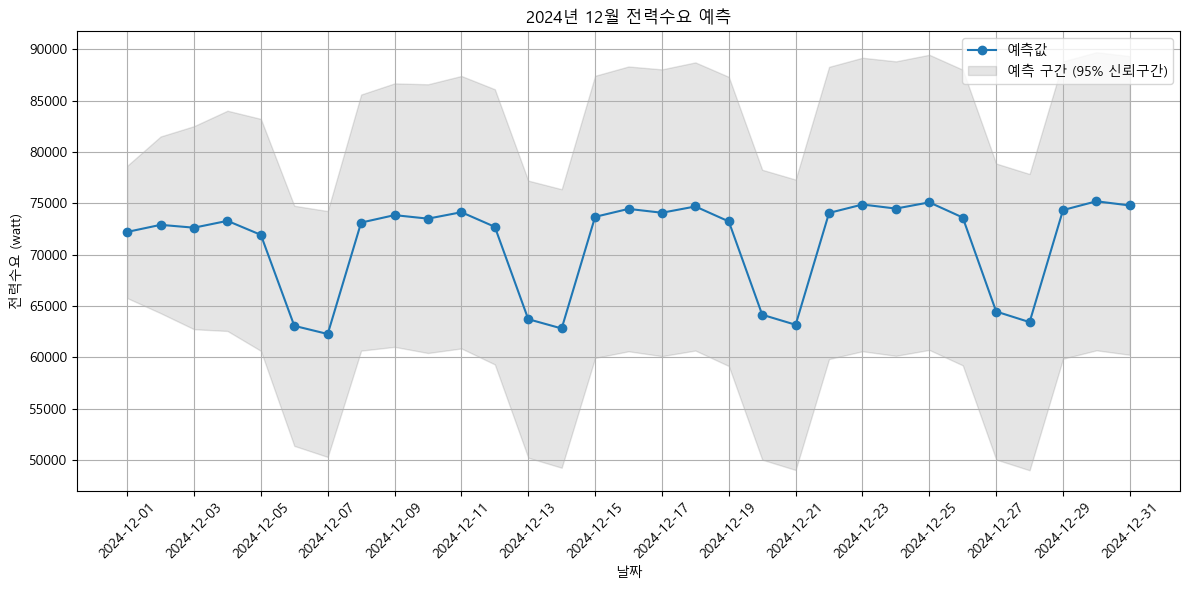

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 예측 결과만 시각화
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['predicted_watt'], label='예측값', marker='o')
plt.fill_between(forecast_df.index,
                 forecast_df['lower_ci'],
                 forecast_df['upper_ci'],
                 color='k',
                 alpha=0.1,
                 label='예측 구간 (95% 신뢰구간)')
plt.xlabel('날짜')
plt.ylabel('전력수요 (watt)')
plt.title('2024년 12월 전력수요 예측')
plt.legend()
plt.grid(True)

# 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))  # 2일 간격으로 표시
plt.xticks(rotation=45)

plt.tight_layout()  # 레이아웃 조정
plt.show()

## log(watt)

In [28]:
# log(watt) 변수를 생성합니다.
data['log_watt'] = np.log(data['watt'])

# log(lagwatt) 변수를 생성합니다.
data['log_lagwatt'] = data['log_watt'].shift(1)  # lag 1

# 결측치 제거 (lag로 인해 생긴 첫 번째 NaN 값)
data = data.dropna()

# 독립 변수와 종속 변수 설정
X = data[['log_lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X = sm.add_constant(X)  # 상수항 추가
y = data['log_watt']


model = sm.tsa.statespace.SARIMAX(y, exog = X,
                                  order=best_order,
                                  seasonal_order=best_seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
log_results = model.fit()

# 결과 출력
print(log_results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                               log_watt   No. Observations:                 5438
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 7)   Log Likelihood               11277.580
Date:                                Tue, 03 Dec 2024   AIC                         -22531.159
Time:                                        20:33:10   BIC                         -22451.994
Sample:                                    01-05-2010   HQIC                        -22503.525
                                         - 11-24-2024                                         
Covariance Type:                                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.109e-11   6.25e-10     -0.034      0.973   -1.25e-09     1.2e-09


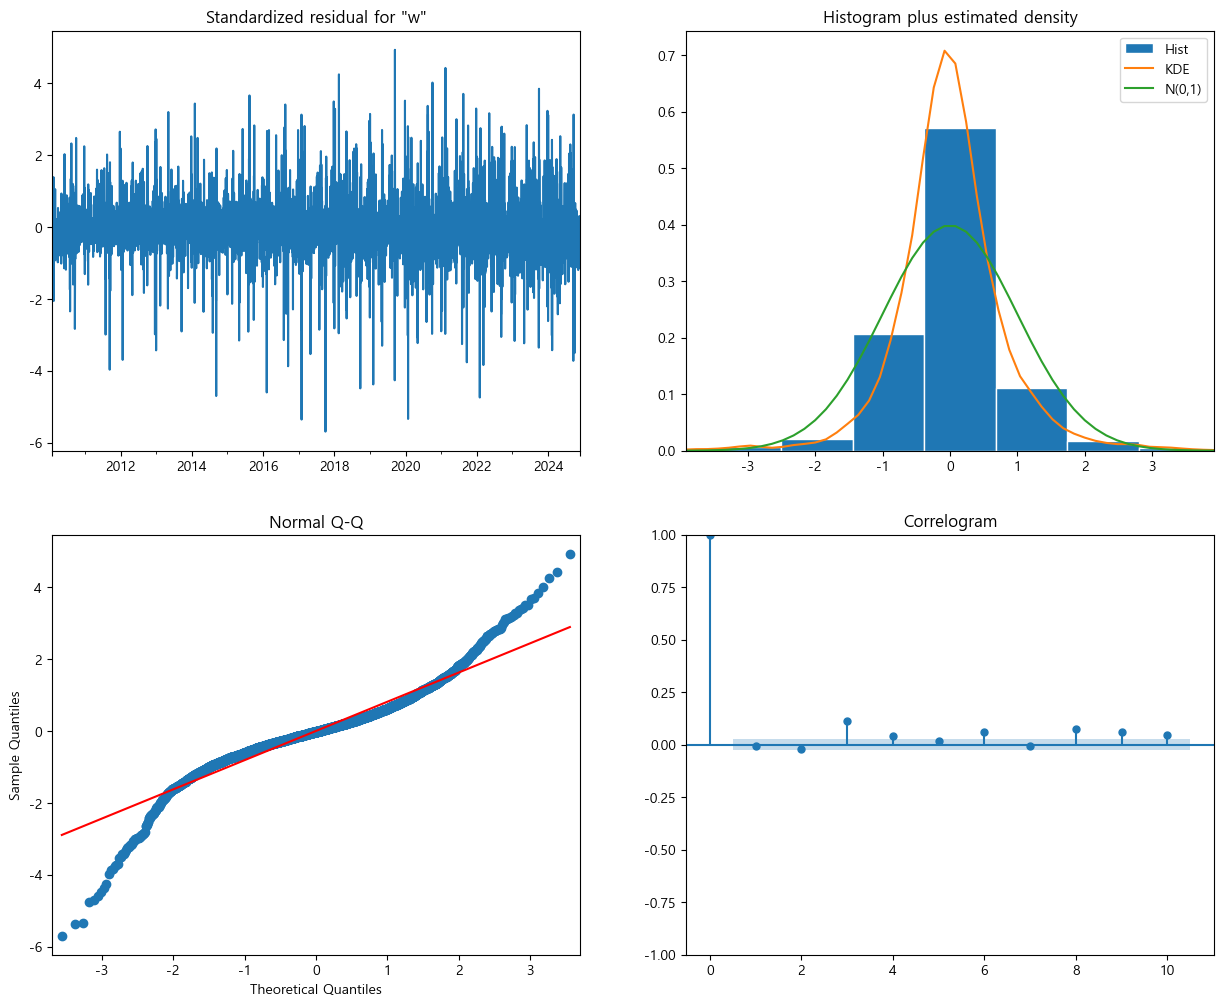

In [29]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [33]:
# log(watt) 변수를 생성합니다.
data['log_watt'] = np.log(data['watt'])

# log(lagwatt) 변수를 생성합니다.
data['log_lagwatt'] = data['log_watt'].shift(1)  # lag 1

# 결측치 제거 (lag로 인해 생긴 첫 번째 NaN 값)
data = data.dropna()

# 독립 변수와 종속 변수 설정
X = data[['log_lagwatt', 'time', 'temp_abs', 'holiday']]
X = sm.add_constant(X)  # 상수항 추가
y = data['log_watt']


model = sm.tsa.statespace.SARIMAX(y, exog = X,
                                  order=best_order,
                                  seasonal_order=best_seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
log_results = model.fit()

# 결과 출력
print(log_results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                               log_watt   No. Observations:                 5436
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 7)   Log Likelihood               11261.359
Date:                                Tue, 03 Dec 2024   AIC                         -22500.719
Time:                                        20:39:17   BIC                         -22428.155
Sample:                                    01-07-2010   HQIC                        -22475.388
                                         - 11-24-2024                                         
Covariance Type:                                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.938e-11   1.41e-09      0.028      0.978   -2.73e-09    2.81e-09


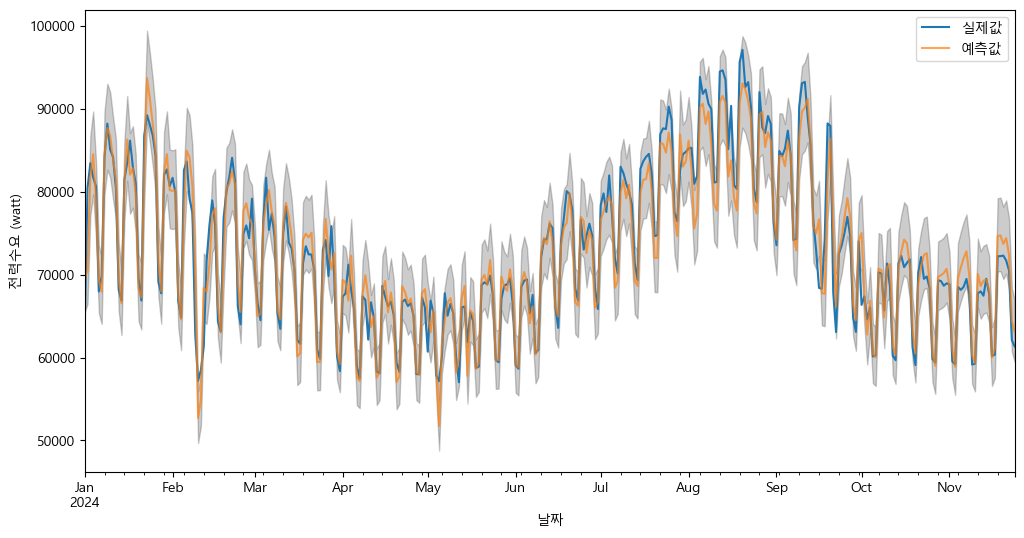

MSE: 5983575.63
MAE: 1821.28
RMSE: 2446.13
MAPE: 2.48%


In [38]:
# 예측값과 예측 구간에 대해 지수 변환
predicted_mean_exp = np.exp(pred.predicted_mean)
pred_ci_exp = np.exp(pred_ci)

# 실제 값도 지수 변환
y_true_exp = test_data['watt']

# 실제 값과 예측값 비교
ax = y_true_exp.plot(label='실제값', figsize=(12, 6))
predicted_mean_exp.plot(ax=ax, label='예측값', alpha=.7)

# 예측 구간 그림
ax.fill_between(pred_ci_exp.index,
                pred_ci_exp.iloc[:, 0],
                pred_ci_exp.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('날짜')
ax.set_ylabel('전력수요 (watt)')
plt.legend()
plt.show()

# 평가 지표 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 평가를 위한 실제 값과 예측값
y_pred_exp = predicted_mean_exp

mse = mean_squared_error(y_true_exp, y_pred_exp)
mae = mean_absolute_error(y_true_exp, y_pred_exp)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true_exp - y_pred_exp) / y_true_exp)) * 100

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

In [40]:
# 전체 데이터로 모델 재적합 후 12월 예측
full_model = sm.tsa.statespace.SARIMAX(data['log_watt'],
                                       order=best_order,
                                       seasonal_order=best_seasonal_order,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
full_results = full_model.fit()

forecast = full_results.get_forecast(steps=len(forecast_dates))
forecast_ci = forecast.conf_int()

# 로그 스케일에서 원래 스케일로 변환
forecast_mean = np.exp(forecast.predicted_mean)
forecast_ci_lower = np.exp(forecast_ci.iloc[:, 0])
forecast_ci_upper = np.exp(forecast_ci.iloc[:, 1])

forecast_df = pd.DataFrame({'date': forecast_dates,
                            'predicted_watt': forecast_mean.values,
                            'lower_ci': forecast_ci_lower.values,
                            'upper_ci': forecast_ci_upper.values})
forecast_df.set_index('date', inplace=True)
forecast_df.round(3)

,predicted_watt,lower_ci,upper_ci
date,,,
2024-12-01,72023.421,66824.850,77626.410
2024-12-02,72942.470,65886.240,80754.402
2024-12-03,72736.320,64648.725,81835.678
2024-12-04,73466.937,64605.516,83543.807
2024-12-05,72093.848,62932.794,82588.465
2024-12-06,63375.752,55034.926,72980.672
2024-12-07,62538.243,54104.774,72286.261
2024-12-08,73253.446,63013.721,85157.124
2024-12-09,74188.574,63545.924,86613.650


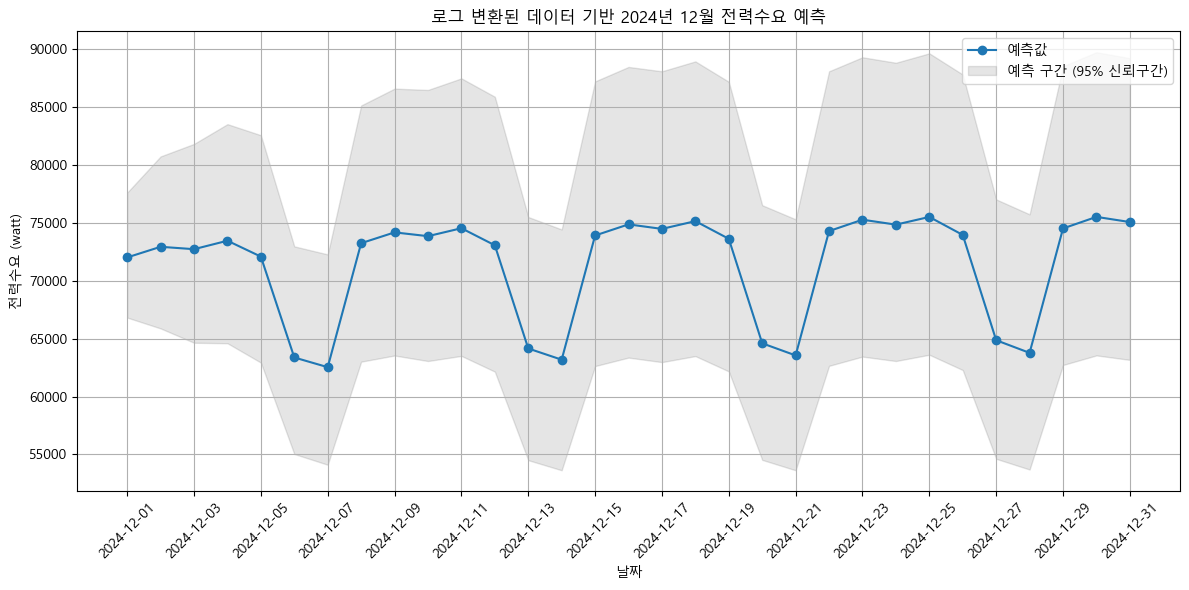

In [41]:
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['predicted_watt'], label='예측값', marker='o')
plt.fill_between(forecast_df.index,
                 forecast_df['lower_ci'],
                 forecast_df['upper_ci'],
                 color='k',
                 alpha=0.1,
                 label='예측 구간 (95% 신뢰구간)')
plt.xlabel('날짜')
plt.ylabel('전력수요 (watt)')
plt.title('로그 변환된 데이터 기반 2024년 12월 전력수요 예측')
plt.legend()
plt.grid(True)

# 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## XGBoost

In [89]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from datetime import timedelta

# 데이터 불러오기
data = pd.read_csv('C:/Users/LG/Desktop/elec/elecdata_20241128.csv')

# 날짜 형식 변환
data['date'] = pd.to_datetime(data['date'])

# 'weekend' 변수 생성
data['weekend'] = data['day'].apply(lambda x: 1 if x in [1, 7] else 0)

# 'temp_abs' 변수 생성: 온도의 절대편차 |temperature - 15|
data['temp_abs'] = np.abs(data['temp'] - 15)

# 'time' 변수 생성 (시간 순서 인덱스)
data['time'] = np.arange(len(data))

# 결측치 확인 및 제거
print(data.isnull().sum())
data = data.dropna()

# 변수 타입 변환
data['weekend'] = data['weekend'].astype(int)
data['holiday'] = data['holiday'].astype(int)

date        0
temp        0
watt        0
pwatt       0
day         0
holiday     0
weekend     0
temp_abs    0
time        0
dtype: int64


,date,temp,watt,pwatt,day,holiday,weekend,temp_abs,time
0,2010-01-01,-4.9,56391,56391,6,0,0,19.9,0
1,2010-01-02,-0.1,55470,56391,7,1,1,15.1,1
2,2010-01-03,-2.9,55581,55470,1,1,1,17.9,2
3,2010-01-04,-1.8,66149,55581,2,1,0,16.8,3
4,2010-01-05,-5.2,66901,66149,3,1,0,20.2,4
...,...,...,...,...,...,...,...,...,...
5437,2024-11-20,7.1,72295,72232,4,1,0,7.9,5437
5438,2024-11-21,9.0,71709,72295,5,1,0,6.0,5438
5439,2024-11-22,7.3,70524,71709,6,1,0,7.7,5439
5440,2024-11-23,5.3,62101,70524,7,1,1,9.7,5440


In [90]:
from sklearn.model_selection import GridSearchCV
# 피쳐와 타깃 변수 설정
features = ['temp', 'pwatt', 'day', 'holiday', 'weekend', 'temp_abs']
target = 'watt'

# 훈련 및 테스트 데이터 분할
train_data = data[data['date'] <= '2023-12-31']
test_data = data[(data['date'] >= '2024-01-01') & (data['date'] <= '2024-11-24')]

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 재학습
best_model = grid_search.best_estimator_

# 테스트 데이터 예측 및 MAE 계산
if not X_test.empty:
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"테스트 데이터의 MAE: {mae:.2f}")
else:
    print("테스트 데이터가 없습니다.")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
최적의 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
테스트 데이터의 MAE: 1976.88


In [91]:
# 향후 30일간의 날짜 생성
last_date = data['date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]
future_df = pd.DataFrame({'date': future_dates})

# 미래 데이터에 필요한 피쳐 생성
future_df['day'] = future_df['date'].dt.weekday + 1
future_df['weekend'] = future_df['day'].apply(lambda x: 1 if x in [1, 7] else 0)
future_df['holiday'] = future_df['weekend'].apply(lambda x: 0 if x == 1 else 1)  # 주말을 공휴일로 간주

# 2023년 11월 24일부터 2023년 12월 23일까지의 온도 데이터 추출
temp_start_date = pd.to_datetime('2023-11-24')
temp_end_date = temp_start_date + timedelta(days=29)
temp_data = data[(data['date'] >= temp_start_date) & (data['date'] <= temp_end_date)]['temp'].reset_index(drop=True)

# 미래 날짜의 온도를 해당 기간의 온도로 설정
if len(temp_data) == 30:
    future_df['temp'] = temp_data
else:
    # 온도 데이터가 30일보다 적으면 반복하여 채움
    repeats = (30 // len(temp_data)) + 1
    temp_data_extended = pd.concat([temp_data]*repeats, ignore_index=True)
    future_df['temp'] = temp_data_extended[:30]

# 'temp_abs' 변수 생성
future_df['temp_abs'] = np.abs(future_df['temp'] - 15)
future_df['time'] = np.arange(len(data), len(data) + 30)

# 'pwatt' 변수 생성: 마지막 날의 'watt' 값을 사용
future_df['pwatt'] = data['watt'].iloc[-1]

# 필요한 피쳐 선택
X_future = future_df[features]

# 미래 데이터 예측
future_predictions = model.predict(X_future)
future_df['watt_prediction'] = future_predictions

# 결과 출력
print(future_df[['date', 'watt_prediction']])

         date  watt_prediction
0  2024-11-25     57898.601562
1  2024-11-26     74038.195312
2  2024-11-27     65287.738281
3  2024-11-28     63504.925781
4  2024-11-29     64583.125000
5  2024-11-30     65040.816406
6  2024-12-01     58671.257812
7  2024-12-02     56835.750000
8  2024-12-03     75490.406250
9  2024-12-04     65678.937500
10 2024-12-05     65328.332031
11 2024-12-06     64583.125000
12 2024-12-07     63318.828125
13 2024-12-08     55301.988281
14 2024-12-09     57420.441406
15 2024-12-10     72499.257812
16 2024-12-11     63404.160156
17 2024-12-12     62718.621094
18 2024-12-13     63560.453125
19 2024-12-14     62692.062500
20 2024-12-15     54990.941406
21 2024-12-16     57737.195312
22 2024-12-17     74809.453125
23 2024-12-18     62236.125000
24 2024-12-19     67633.812500
25 2024-12-20     67338.929688
26 2024-12-21     67662.210938
27 2024-12-22     58800.824219
28 2024-12-23     54717.875000
29 2024-12-24     73597.890625


In [96]:
# 부트스트랩 반복 횟수
n_bootstraps = 100

for i in range(n_bootstraps):
    # 데이터 샘플링
    sample_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_sample = X_train.iloc[sample_indices]
    y_sample = y_train.iloc[sample_indices]

    # 모델 재학습
    model = xgb.XGBRegressor(objective='reg:squarederror', **grid_search.best_params_)
    model.fit(X_sample, y_sample)

    # 예측값 저장
    preds = model.predict(X_future)
    bootstrap_preds.append(preds)

# 예측값의 분포로부터 신뢰 구간 계산
preds_array = np.array(bootstrap_preds)
lower_ci = np.percentile(preds_array, 2.5, axis=0)
upper_ci = np.percentile(preds_array, 97.5, axis=0)


# 신뢰 구간을 데이터프레임에 추가
future_df['lower_ci'] = lower_ci
future_df['upper_ci'] = upper_ci

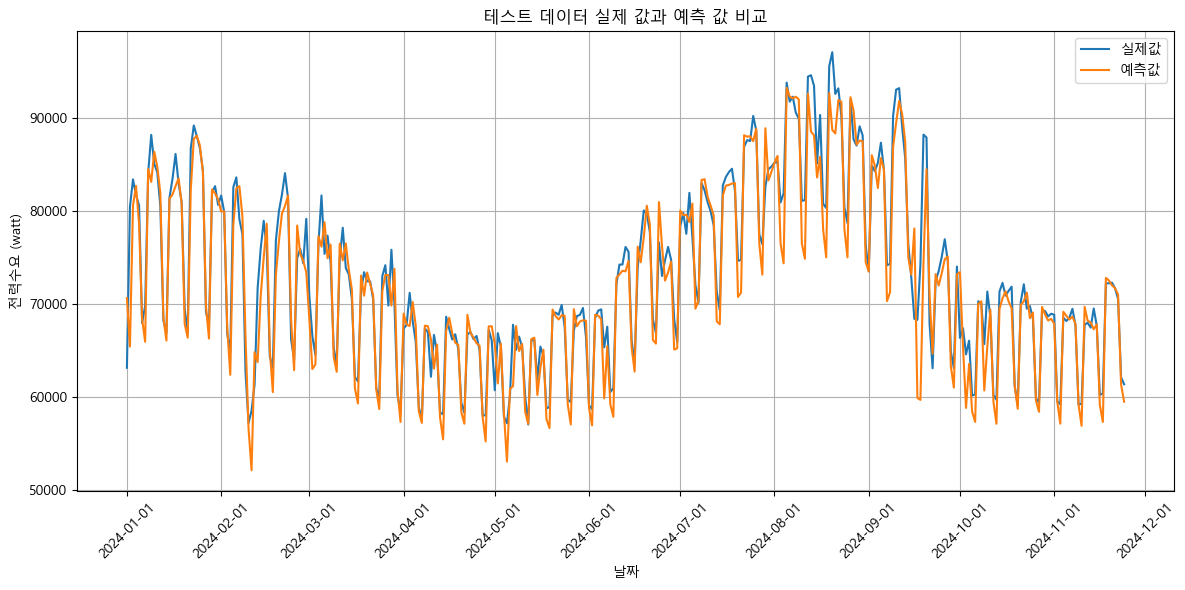

In [92]:
# 날짜 인덱스 설정
test_data = test_data.copy()
test_data.set_index('date', inplace=True)
pred_df = pd.DataFrame({'예측값': y_pred}, index=test_data.index)
actual_df = pd.DataFrame({'실제값': y_test.values}, index=test_data.index)
    
    # 실제 값과 예측 값 합치기
compare_df = pd.concat([actual_df, pred_df], axis=1)
    
    # 플롯 그리기
plt.figure(figsize=(12, 6))
plt.plot(compare_df.index, compare_df['실제값'], label='실제값')
plt.plot(compare_df.index, compare_df['예측값'], label='예측값')
plt.xlabel('날짜')
plt.ylabel('전력수요 (watt)')
plt.title('테스트 데이터 실제 값과 예측 값 비교')
plt.legend()
plt.grid(True)
    
    # 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

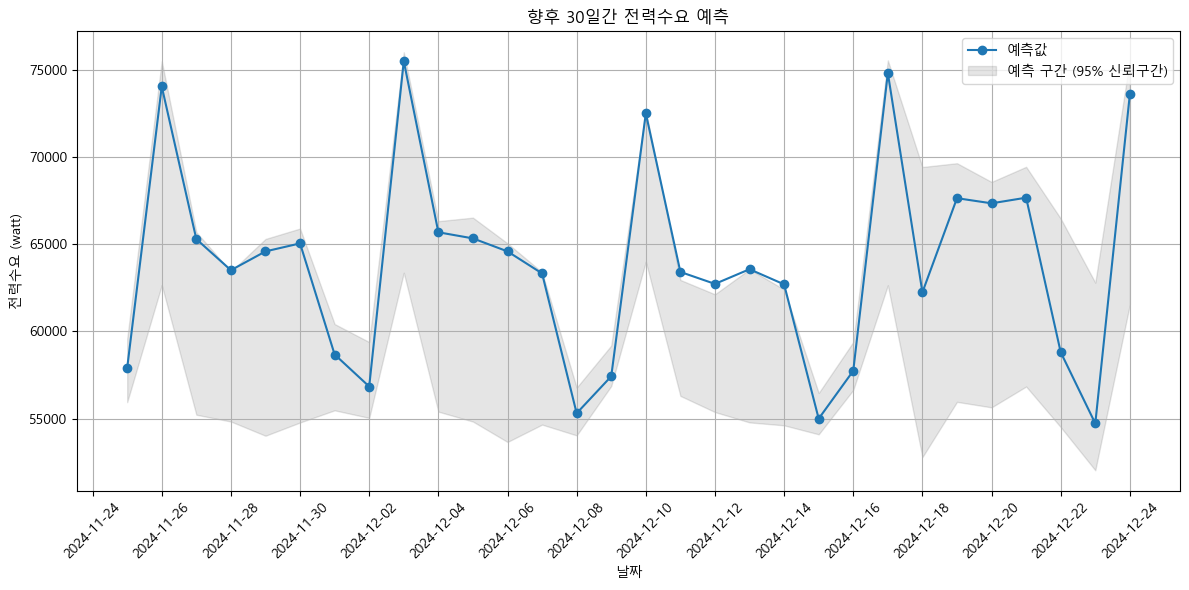

In [97]:
# 날짜 열을 인덱스로 설정하고 datetime 형식으로 변환
future_df.reset_index(inplace=True)  # 기존 인덱스를 제거
future_df['date'] = pd.to_datetime(future_df['date'])  # 날짜 형식을 datetime으로 변환
future_df.set_index('date', inplace=True)  # date 열을 인덱스로 설정

# ===============================
# 예측 결과 시각화
# ===============================
plt.figure(figsize=(12, 6))
plt.plot(future_df.index, future_df['watt_prediction'], label='예측값', marker='o')
plt.fill_between(future_df.index,
                 future_df['lower_ci'],
                 future_df['upper_ci'],
                 color='k',
                 alpha=0.1,
                 label='예측 구간 (95% 신뢰구간)')
plt.xlabel('날짜')
plt.ylabel('전력수요 (watt)')
plt.title('향후 30일간 전력수요 예측')
plt.legend()
plt.grid(True)

# 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 2-2. log(watt)에 설명변수를 사용한 회귀모형 2

In [13]:
import statsmodels.api as sm
import numpy as np

# log(watt) 변수를 생성합니다.
data['log_watt'] = np.log(data['watt'])

# log(lagwatt) 변수를 생성합니다.
data['log_lagwatt'] = data['log_watt'].shift(1)  # lag 1

# 결측치 제거 (lag로 인해 생긴 첫 번째 NaN 값)
data = data.dropna()

# 독립 변수와 종속 변수 설정
X = data[['log_lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X = sm.add_constant(X)  # 상수항 추가
y = data['log_watt']

# SARIMAX 모형 적합
# order=(8, 0, 0)은 AR(8)을 나타내며, exog를 통해 외생 변수를 포함합니다.
model = sm.tsa.SARIMAX(y, exog=X, order=(8, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# 결과 출력
print(results.summary())


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               log_watt   No. Observations:                 4016
Model:               SARIMAX(8, 0, 0)   Log Likelihood                7969.217
Date:                Thu, 31 Oct 2024   AIC                         -15908.433
Time:                        08:03:04   BIC                         -15813.992
Sample:                             0   HQIC                        -15874.960
                               - 4016                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.3177      0.095     77.183      0.000       7.132       7.504
log_lagwatt     0.3188      0.009     36.443      0.000       0.302       0.336
time         3.184e-05   1.72e-06     18.459    

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                             log_watt   No. Observations:                 5441
Model:             SARIMAX(8, 0, 0)x(1, 1, [1], 12)   Log Likelihood               10660.021
Date:                              Sun, 01 Dec 2024   AIC                         -21286.043
Time:                                      20:55:32   BIC                         -21173.914
Sample:                                  01-02-2010   HQIC                        -21246.899
                                       - 11-24-2024                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.185e-09   1.47e-06     -0.001      0.999   -2.88e-06    2.87e-06
lag_logwatt     

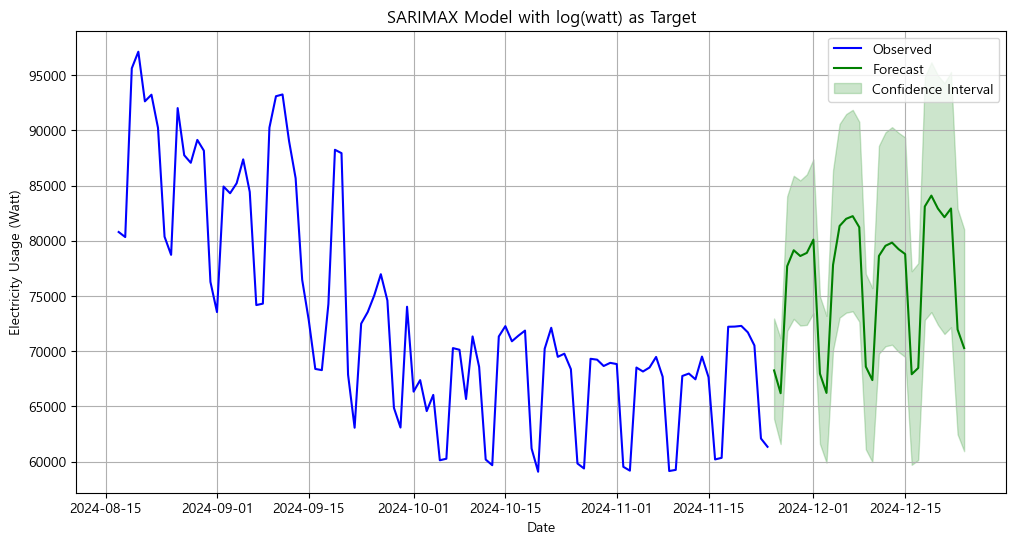

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('elecdata.csv')  # Replace with your dataset path
data['date'] = pd.to_datetime(data['date'])  # Convert date to datetime
data.set_index('date', inplace=True)

# Log-transform the target variable
data['log_watt'] = np.log(data['watt'])

# Create lagged variable for log(watt)
data['lag_logwatt'] = data['log_watt'].shift(1)

# Remove rows with missing values due to lagging
data = data.dropna()

# Define independent variables (explanatory variables)
X = data[['lag_logwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X = sm.add_constant(X)  # Add constant term

# Define dependent variable (target)
y = data['log_watt']

# Fit SARIMAX model with log(watt) as the target variable
sarimax_model = SARIMAX(
    y,
    exog=X,
    order=(8, 0, 0),  # Non-seasonal ARIMA components
    seasonal_order=(1, 1, 1, 12),  # Seasonal ARIMA components with period=12
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# Fit the model
sarimax_result = sarimax_model.fit()

# Model summary
print(sarimax_result.summary())

# Forecast the next 30 days
future_exog = X[-30:]  # Use the last 30 rows of explanatory variables for forecasting
forecast = sarimax_result.get_forecast(steps=30, exog=future_exog)
forecast_mean = np.exp(forecast.predicted_mean)  # Reverse log transformation
forecast_ci = np.exp(forecast.conf_int())  # Reverse log transformation for confidence interval

# Plot the observed data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['watt'][-100:], label='Observed', color='blue')
plt.plot(forecast_mean, label='Forecast', color='green')
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title("SARIMAX Model with log(watt) as Target")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (Watt)")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
!pip install h2o

     -------------------------------------- 265.8/265.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859805 sha256=c7c464b7c15181c577466c24550db092b78404cb167e06969ef4538db160b871
  Stored in directory: c:\users\lg\appdata\local\pip\cache\wheels\3a\26\82\7efecb0002612b1e1fdba42dbf2426f39cba1bb92334567209
Successfully built h2o


Checking whether there is an H2O instance running at http://localhost:54321..... connected.


H2O_cluster_uptime:,2 mins 14 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_LG_eefee8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,49.41 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
21:53:21.76: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     mae     rmse          mse      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20241203_215320     1233.47  1812.8   3.28624e+06  0.0270376               3.28624e+06
StackedEnsemble_BestOfFamily_1_AutoML_1_20241203_215320  1259.53  1848.9   3.41843e+06  0.0275698               3.41843e+06
GBM_3_AutoML_1_20241203_215320                           1275.61  1872.56  3.5065e+06   0.0279651               3.5065e+06
GBM_4_AutoML_1_20241203_215320                           1278.06  1877.62  3.52546e+06  0.027962                3.52546e+06
GBM_2_AutoML_1_20241203_215320    

C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


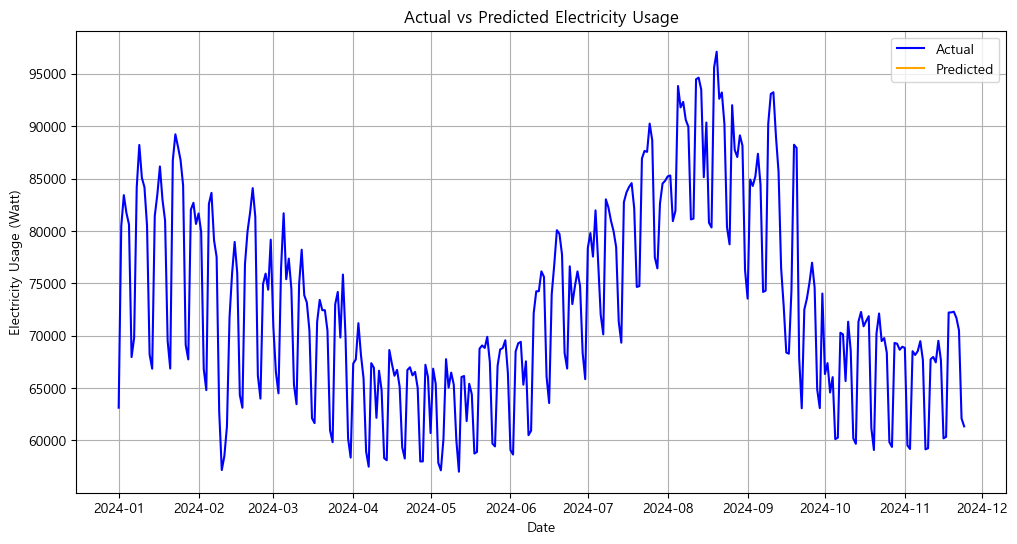

C:\Users\LG\AppData\Local\Temp\ipykernel_4436\1204109155.py:54: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


H2O session _sid_86ae closed.


In [59]:
import h2o
from h2o.automl import H2OAutoML

# Initialize H2O cluster
h2o.init()

# Load the dataset
data['date'] = pd.to_datetime(data['date'])  # Convert date to datetime
data.set_index('date', inplace=True)

# Feature engineering
data['lagwatt'] = data['watt'].shift(1)  # Lagged feature
data = data.dropna()  # Remove missing values caused by lagging

# Split into train and test datasets
train = data.loc[:'2023']  # Example: Data until 2022 for training
test = data.loc['2024':]  # Example: Data from 2023 for testing

# Convert train and test data to H2OFrame
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

# Define target and features
target = 'watt'
features = ['lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']

# Train AutoML model
aml = H2OAutoML(max_models=20, seed=42, sort_metric="MAE")
aml.train(x=features, y=target, training_frame=train_h2o)

# Display AutoML leaderboard
leaderboard = aml.leaderboard
print(leaderboard)

# Make predictions on the test set
predictions = aml.leader.predict(test_h2o)

# Reverse log transformation for actual watt predictions
test['predicted_watt'] = np.exp(h2o.as_list(predictions)['predict'])

# Plot the actual vs predicted watt
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(test['watt'], label='Actual', color='blue')
plt.plot(test['predicted_watt'], label='Predicted', color='orange')
plt.title("Actual vs Predicted Electricity Usage")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (Watt)")
plt.legend()
plt.grid(True)
plt.show()

# Shut down H2O cluster
h2o.shutdown(prompt=False)

### 2-3 모형 1, 2로 예측 수행

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 테스트 데이터 범위 설정
start_date = '2020-12-17'
end_date = '2020-12-31'
test_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# 독립 변수 준비
X_train = data[['lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X_train = sm.add_constant(X_train)

# 일반 회귀모형 - SARIMAX를 통해 훈련
y_train = data['watt']
model_watt = sm.tsa.SARIMAX(y_train, exog=X_train, order=(8, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results_watt = model_watt.fit()

# 테스트 데이터에 대한 독립 변수
X_test = test_data[['lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X_test = sm.add_constant(X_test)

# 일반 회귀모형 예측
forecast_watt = results_watt.predict(start=len(data) - len(test_data), end=len(data) - 1, exog=X_test)

# log(watt) 회귀모형 준비
data['log_watt'] = np.log(data['watt'])
data['log_lagwatt'] = data['log_watt'].shift(1)
data = data.dropna()

X_train_log = data[['log_lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X_train_log = sm.add_constant(X_train_log)
y_train_log = data['log_watt']

# log(watt) 회귀모형 - SARIMAX를 통해 훈련
model_log_watt = sm.tsa.SARIMAX(y_train_log, exog=X_train_log, order=(8, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
results_log_watt = model_log_watt.fit()

# 테스트 데이터에 대한 독립 변수 (log 모델용)
test_data['log_lagwatt'] = np.log(test_data['watt'].shift(1))
X_test_log = test_data[['log_lagwatt', 'time', 'temp_abs', 'weekend', 'holiday']]
X_test_log = sm.add_constant(X_test_log)

# log(watt) 회귀모형 예측 (예측 후 지수화하여 원래 단위로 복원)
forecast_log_watt = results_log_watt.predict(start=len(data) - len(test_data), end=len(data) - 1, exog=X_test_log)
forecast_log_watt_exp = np.exp(forecast_log_watt)  # 지수화하여 원래 단위로 복원

# 예측 결과를 하나의 데이터프레임으로 정리
forecast_results = pd.DataFrame({
    'Date': test_data['date'],
    'Forecast_Watt': forecast_watt,
    'Forecast_Log_Watt': forecast_log_watt_exp
})

print(forecast_results)

C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

           Date  Forecast_Watt  Forecast_Log_Watt
4003 2020-12-17   85600.630011       87476.208291
4004 2020-12-18   81391.578943       81810.903461
4005 2020-12-19   72431.810888       72269.692860
4006 2020-12-20   68206.171377       67827.246020
4007 2020-12-21   79493.895274       79073.094815
4008 2020-12-22   81415.486453       80835.307716
4009 2020-12-23   81555.992082       80637.421207
4010 2020-12-24   80503.369911       79027.211784
4011 2020-12-25   71415.151254       69904.757038
4012 2020-12-26   64764.881808       64030.840330
4013 2020-12-27   63055.133449       62179.703469
4014 2020-12-28   75782.292348       74967.849248
4015 2020-12-29   78662.276510       79622.184968
4016 2020-12-30   83740.126959       88002.191310
4017 2020-12-31   83344.569343       86474.070160


In [15]:
forecast_results = pd.DataFrame({
    'Date': test_data['date'],
    'Forecast_Watt': forecast_watt,
    'Forecast_Log_Watt': forecast_log_watt_exp,
    'Actual_Watt': test_data['watt'].values
})

forecast_results['Error_Watt'] = forecast_results['Forecast_Watt'] - forecast_results['Actual_Watt']
forecast_results['Error_Log_Watt'] = forecast_results['Forecast_Log_Watt'] - forecast_results['Actual_Watt']
forecast_results['Absolute_Error_Watt'] = abs(forecast_results['Error_Watt'])
forecast_results['Absolute_Error_Log_Watt'] = abs(forecast_results['Error_Log_Watt'])
forecast_results['Absolute_Error_Percentage_Watt'] = forecast_results['Absolute_Error_Watt'] / forecast_results['Actual_Watt']
forecast_results['Absolute_Error_Percentage_Log_Watt'] = forecast_results['Absolute_Error_Log_Watt'] / forecast_results['Actual_Watt']


forecast_results

,Date,Forecast_Watt,Forecast_Log_Watt,Actual_Watt,Error_Watt,Error_Log_Watt,Absolute_Error_Watt,Absolute_Error_Log_Watt,Absolute_Error_Percentage_Watt,Absolute_Error_Percentage_Log_Watt
4003,2020-12-17,85600.630011,87476.208291,84185.0,1415.630011,3291.208291,1415.630011,3291.208291,0.016816,0.039095
4004,2020-12-18,81391.578943,81810.903461,82899.0,-1507.421057,-1088.096539,1507.421057,1088.096539,0.018184,0.013126
4005,2020-12-19,72431.810888,72269.692860,69628.0,2803.810888,2641.692860,2803.810888,2641.692860,0.040268,0.037940
4006,2020-12-20,68206.171377,67827.246020,66560.0,1646.171377,1267.246020,1646.171377,1267.246020,0.024732,0.019039
4007,2020-12-21,79493.895274,79073.094815,82906.0,-3412.104726,-3832.905185,3412.104726,3832.905185,0.041156,0.046232
4008,2020-12-22,81415.486453,80835.307716,82109.0,-693.513547,-1273.692284,693.513547,1273.692284,0.008446,0.015512
4009,2020-12-23,81555.992082,80637.421207,81349.0,206.992082,-711.578793,206.992082,711.578793,0.002544,0.008747
4010,2020-12-24,80503.369911,79027.211784,77124.0,3379.369911,1903.211784,3379.369911,1903.211784,0.043817,0.024677
4011,2020-12-25,71415.151254,69904.757038,67327.0,4088.151254,2577.757038,4088.151254,2577.757038,0.060721,0.038287
4012,2020-12-26,64764.881808,64030.840330,63604.0,1160.881808,426.840330,1160.881808,426.840330,0.018252,0.006711


#### 실제값과 오차, 오차의 절대값, 오차의 절댓값 / 실제값 을 하나의 데이터 프레임에 정리

### 2-4 XGBoost 모형으로 예측 수행

### 2-5 MAE 계산

In [17]:
from sklearn.metrics import mean_absolute_error

# MAE 계산
# 일반 회귀모형의 MAE
mae_linear = mean_absolute_error(forecast_results['Actual_Watt'], forecast_results['Forecast_Watt'])

# log(watt) 자기회귀모형의 MAE (지수 변환된 값 사용)
mae_log_watt = mean_absolute_error(forecast_results['Actual_Watt'], forecast_results['Forecast_Log_Watt'])

# XGBoost 회귀모형의 MAE
mae_xgboost = mean_absolute_error(forecast_results_xgb['Actual_Watt'], forecast_results_xgb['Forecast_XGBoost_Watt'])

# 결과를 정리하여 출력
mae_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Log(Watt) AR Model', 'XGBoost'],
    'MAE': [mae_linear, mae_log_watt, mae_xgboost]
})

# 가장 낮은 MAE 값을 가진 모델을 선택
best_model = mae_results.loc[mae_results['MAE'].idxmin()]

print(mae_results)
print("\nBest Model based on MAE:")
print(best_model)


                Model          MAE
0   Linear Regression  1646.070242
1  Log(Watt) AR Model  2143.008190
2             XGBoost  1429.049740

Best Model based on MAE:
Model       XGBoost
MAE      1429.04974
Name: 2, dtype: object


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 23 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_LG_wb5hg6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,232.6 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


date        0
temp        0
watt        0
pwatt       0
day         0
holiday     0
weekend     0
temp_abs    0
time        0
dtype: int64
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
00:35:43.992: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    mae     rmse          mse      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20241204_03543  2344.53  3364.45  1.13195e+07  0.0494213               1.13195e+07
StackedEnsemble_AllModels_1_AutoML_1_20241204_03543     2351.26  3355.06  1.12564e+07  0.0493058               1.12564e+07
GBM_grid_1_AutoML_1_20241204_03543_model_1              2354.83  3370.66  1.13614e+07  0.0495397               1.13614e+07
GBM_grid_1_AutoML_1_2

C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


테스트 데이터 MAE: 3067.44
테스트 데이터 RMSE: 4300.25
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\LG\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


            predicted_watt
date                      
2024-12-01    63953.820435
2024-12-02    64537.973804
2024-12-03    64560.524236
2024-12-04    64560.199923
2024-12-05    64560.168878
2024-12-06    64560.165907
2024-12-07    64560.165622
2024-12-08    64560.165595
2024-12-09    64560.165592
2024-12-10    64560.165592
2024-12-11    64560.165592
2024-12-12    64560.165592
2024-12-13    64560.165592
2024-12-14    64560.165592
2024-12-15    64560.165592
2024-12-16    64560.165592
2024-12-17    64560.165592
2024-12-18    64560.165592
2024-12-19    64560.165592
2024-12-20    64560.165592
2024-12-21    64560.165592
2024-12-22    64560.165592
2024-12-23    64560.165592
2024-12-24    64560.165592
2024-12-25    64560.165592
2024-12-26    64560.165592
2024-12-27    64560.165592
2024-12-28    64560.165592
2024-12-29    64560.165592
2024-12-30    64560.165592
2024-12-31    64560.165592


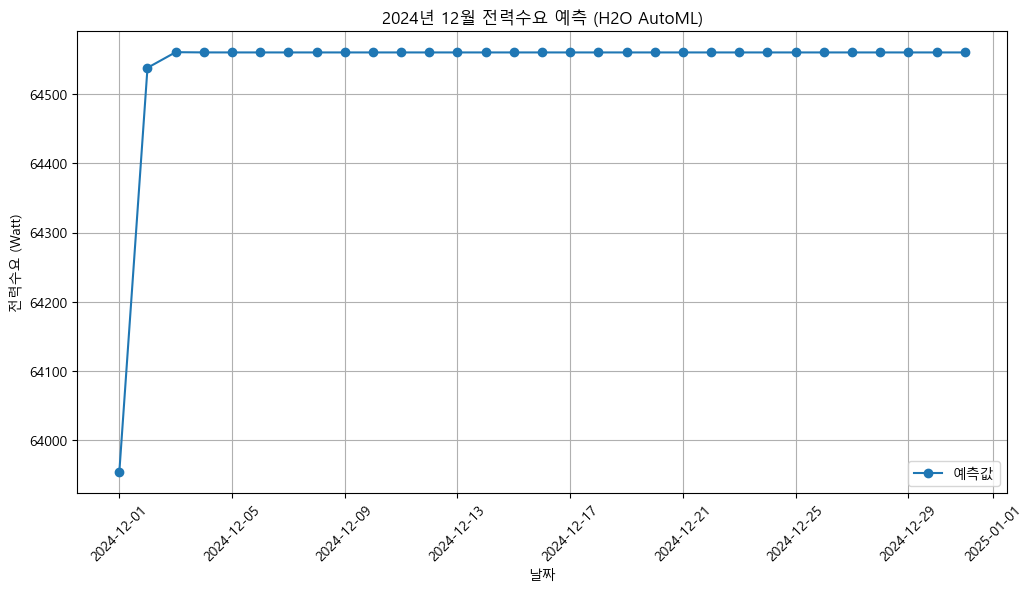

C:\Users\LG\AppData\Local\Temp\ipykernel_4436\1551364219.py:105: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


H2O session _sid_a7a0 closed.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. H2O 클러스터 초기화
h2o.init()

# 2. 데이터 로드 및 전처리
# 데이터 불러오기
data = pd.read_csv('C:/Users/LG/Desktop/elec/elecdata_20241128.csv')

# 날짜 형식 변환
data['date'] = pd.to_datetime(data['date'])

# 'weekend' 변수 생성
data['weekend'] = data['day'].apply(lambda x: 1 if x in [1, 7] else 0)

# 'temp_abs' 변수 생성: 온도의 절대편차 |temperature - 15|
data['temp_abs'] = np.abs(data['temp'] - 15)

# 'time' 변수 생성 (시간 순서 인덱스)
data['time'] = np.arange(len(data))

# 변수 타입 변환
data.set_index('date', inplace=True)
data['lagwatt'] = data['watt'].shift(1)
data = data.dropna()

# 3. 데이터 분할
train = data.loc[:'2023-12-31']
test = data.loc['2024-01-01':'2024-11-24']
forecast_dates = pd.date_range(start='2024-12-01', end='2024-12-31', freq='D')

# 4. H2OFrame으로 변환
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

# 5. 목표 변수와 특징 변수 정의
target = 'watt'
features = ['lagwatt', 'temp_abs', 'holiday', 'weekend']

# 6. AutoML 모델 학습
aml = H2OAutoML(max_models=20, seed=42, sort_metric="MAE")
aml.train(x=features, y=target, training_frame=train_h2o)

# 7. 리더보드 확인 및 최적 모델 선택
leaderboard = aml.leaderboard
print(leaderboard.head())
best_model = aml.leader

# 8. 테스트 데이터에 대한 예측 및 성능 평가
predictions = best_model.predict(test_h2o)
predictions_df = predictions.as_data_frame()
test_results = test.copy()
test_results['predicted_watt'] = predictions_df['predict'].values
mae = mean_absolute_error(test_results['watt'], test_results['predicted_watt'])
rmse = np.sqrt(mean_squared_error(test_results['watt'], test_results['predicted_watt']))
print(f"테스트 데이터 MAE: {mae:.2f}")
print(f"테스트 데이터 RMSE: {rmse:.2f}")

# 9. 12월 데이터 생성 및 예측
future = pd.DataFrame(index=forecast_dates)
last_watt = test.iloc[-1]['watt']
future['lagwatt'] = np.nan
future.iloc[0, future.columns.get_loc('lagwatt')] = last_watt

# 순차적으로 'lagwatt' 업데이트 및 예측 수행
future_predictions = []
for i in range(len(future)):
    current_data = future.iloc[i].to_frame().T
    current_h2o = h2o.H2OFrame(current_data)
    pred = best_model.predict(current_h2o)
    pred_value = pred.as_data_frame()['predict'].values[0]
    future_predictions.append(pred_value)
    if i < len(future) - 1:
        future.iloc[i + 1, future.columns.get_loc('lagwatt')] = pred_value

# 예측 결과 정리
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'predicted_watt': future_predictions
})
forecast_df.set_index('date', inplace=True)
print(forecast_df)

# 10. 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['predicted_watt'], label='예측값', marker='o')
plt.xlabel('날짜')
plt.ylabel('전력수요 (Watt)')
plt.title('2024년 12월 전력수요 예측 (H2O AutoML)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 11. H2O 클러스터 종료
h2o.shutdown(prompt=False)